In [2]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
def standard_units(x):
    """Convert array x to standard units."""
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean) / std

(back to slides)
# Linear Regression

In [4]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in this class


def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_table(r):
    """
    Generate a table of 1000 x,y data points in standard units
    whose correlation is approximately equal to r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

Let's look at an example where our data is linearly correlated

In [ ]:
example = r_table(0.99)
example.show(3)

`example` is a table of 1k examples where `x` and `y` have a correlation coefficient of 0.99



**Question:** How could we visualize the correlation?

<details>
<summary>Solution</summary>
  example.scatter('x', 'y')
</details>

In [ ]:
example.scatter('x', 'y')
resize_window()

Let's now make our predictions

In [ ]:
def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = example.where('x', are.between(x_val - .25, x_val + .25))
    return np.mean(neighbors.column('y'))

**Question:** What should our `y` value be when `x` is 0?

In [ ]:
nn_prediction_example(0)

**Question** What about when `x` is 2 or -2?

In [ ]:
nn_prediction_example(2), nn_prediction_example(-2)

Now let's apply the prediction function to our table

In [ ]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

In [ ]:
example

Let's plot the predictions (in yellow)

In [ ]:
example.scatter('x')
resize_window()

In [ ]:
example.scatter('x')
draw_line(slope=1, color='dodgerblue')
resize_window()

Now let's make a new table where the data is not linearly correlated

In [ ]:
example = r_table(0)
example.scatter('x', 'y')
resize_window()

In [ ]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=0, color='dodgerblue')
resize_window()

Now let's look at an example where the scatter plot is oval shaped

In [ ]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()

(back to slides)

# Linear regression: defining the line


In [10]:
# Copy-pasted from above
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

**Question:** let's compute the slope and intercept

<details>
<summary>Equation</summary>
  ![image.png](slope_intercept_eq.png)
</details>


<!-- copy the equation markdown to this cell and change the cell to markdown -->
(put equation here)

In [13]:
def slope(t, x, y):
    # r * standard_dev(y) / standard_dev(x)
    x_array = t.column(x)
    y_array = t.column(y)
    r = correlation(t, x, y)
    
    return r * np.std(y_array) / np.std(x_array)
    

def intercept(t, x, y):
    # mean(y) - slope * mean(x)
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

In [ ]:
example = r_table(0.5)
slope(example, 'x', 'y')

In [ ]:
intercept(example, 'x', 'y')

In [ ]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=0.5, color='dodgerblue')
resize_window()

(back to slides)

# Root Mean Squared Error

In [5]:
little_women = Table().read_table('https://www.inferentialthinking.com/data/little_women.csv')
little_women

Characters,Periods
21759,189
22148,188
20558,231
25526,195
23395,255
14622,140
14431,131
22476,214
33767,337
18508,185


In [7]:
avg_sent_length = little_women.column('Characters') / little_women.column('Periods')

little_women.with_columns('avg sentence length', avg_sent_length)

Characters,Periods,avg sentence length
21759,189,115.127
22148,188,117.809
20558,231,88.9957
25526,195,130.903
23395,255,91.7451
14622,140,104.443
14431,131,110.16
22476,214,105.028
33767,337,100.199
18508,185,100.043


In [6]:
little_women.num_rows

47

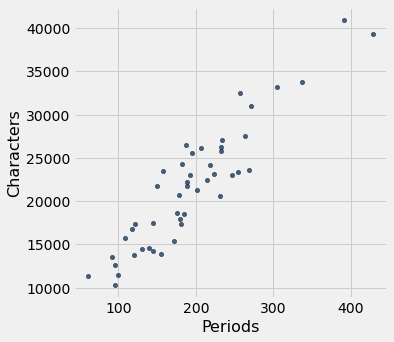

In [8]:
little_women.scatter(1,0)

**Question:** Do we think there is a linear association here?

In [11]:
correlation(little_women, 'Periods', 'Characters')

0.9229576895854816

**Question:** Let's compute the correlation

In [12]:
correlation(little_women, 1, 0)

0.9229576895854816

Now lets predict the number of characters based on the number of periods in a chapter

In [17]:
def fitted_values(tbl, column_1_name, column_2_name):
    # su_y = r * su_x
    # y = slope * x + intercept
    # make a prediction of values in column2 based on column1
    x = tbl.column(column_1_name)
    pred_y = slope(tbl, column_1_name, column_2_name) * x + intercept(tbl, column_1_name, column_2_name)
    return pred_y

In [19]:
pred_characters = fitted_values(little_women, 'Periods', 'Characters') #
pred_characters 

array([21183.59679439, 21096.61895313, 24836.66612724, 21705.46384194,
       26924.13431744, 16921.68257274, 16138.88200141, 23358.04282585,
       34056.31730062, 20835.68542936, 21531.50815943, 42058.27869638,
       19965.90701678, 20400.79622307, 20487.77406433, 19704.973493  ,
       18226.35019161, 17269.59393777, 15269.10358883, 17356.57177903,
       28141.82409506, 15182.12574757, 26228.31158737, 20574.75190559,
       12659.76835108, 17791.46098532, 14225.36949373, 28315.77977757,
       25010.62180976, 23705.95419088, 20226.84054055, 24227.82123843,
       24923.6439685 , 27098.08999996, 22227.33088949, 13442.5689224 ,
       18400.30587413, 22662.22009578, 27619.95704751, 10050.43311333,
       21009.64111188, 15008.17006505, 31273.02638036, 13007.67971611,
       13094.65755737, 25097.59965102, 38840.09856983])

In [20]:
little_women.show(1)

Characters,Periods
21759,189


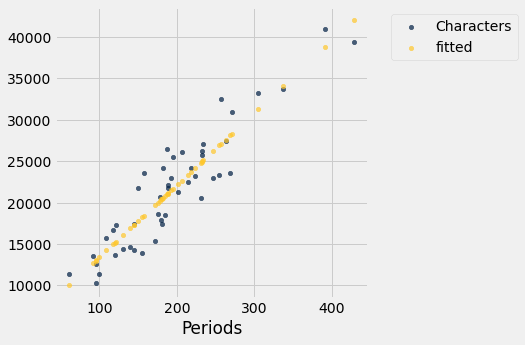

In [21]:
little_women_fitted = little_women.with_columns("fitted", pred_characters)
#little_women_fitted.hist() # What does this histogram mean? 
# Then lets uncomment the next line to look at the scatter of the predictions
little_women_fitted.scatter(1)

## Squared Error

This function will draw a line with a specified slope and intercept and will draw red lines showing the errors

In [22]:
sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
def lw_errors(slope, intercept):
    print("Slope:      ", np.round(slope), 'characters per period')
    print("Intercept:  ", np.round(intercept), 'characters')
    little_women.scatter('Periods', 'Characters')
    xlims = np.array([50, 450])
    plots.plot(xlims, slope * xlims + intercept, lw=2)
    for x,y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=2)

Slope:       50 characters per period
Intercept:   1000 characters


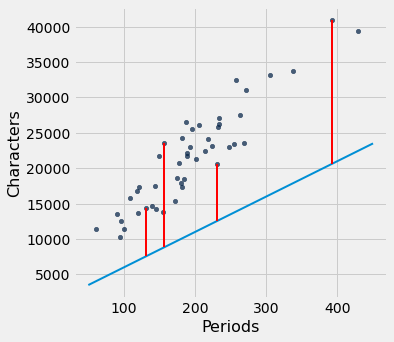

In [23]:
lw_errors(50, 1000)

Slope:       100 characters per period
Intercept:   1000 characters


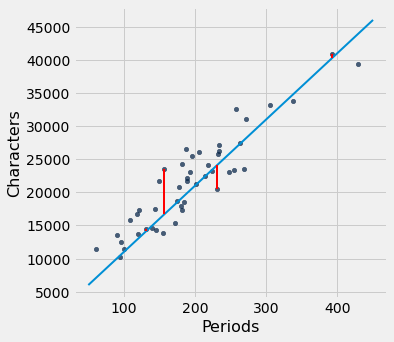

In [24]:
lw_errors(100, 1000)

Let's try it with more slopes and intercepts

Slope:       70 characters per period
Intercept:   1000 characters


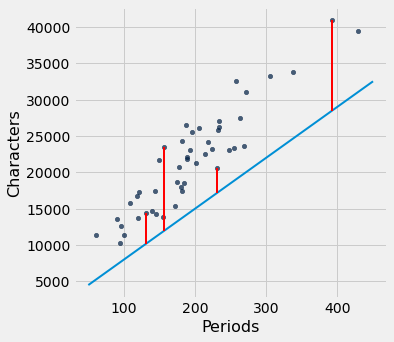

In [25]:
lw_errors(70, 1000)

Slope:       80 characters per period
Intercept:   4000 characters


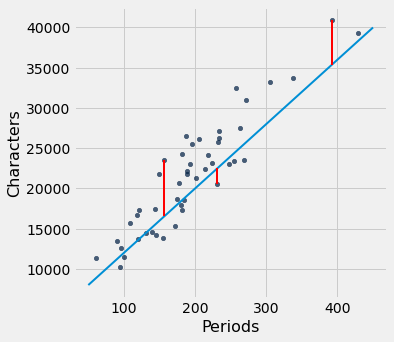

In [31]:
lw_errors(80, 4000)

In [32]:
slope(little_women, 'Periods', 'Characters')

86.97784125829821

In [33]:
intercept(little_women, 'Periods', 'Characters')

4744.784796574928

Slope:       87.0 characters per period
Intercept:   4745.0 characters


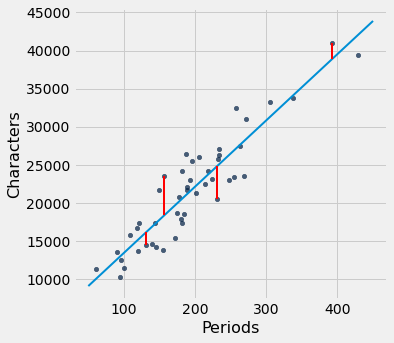

In [34]:
lw_errors(slope(little_women, 'Periods', 'Characters'), intercept(little_women, 'Periods', 'Characters'))

Lets make a line that goes through part of the scatter diagram

Now let's compute the root mean square error for the differnt lines we just considered


<details>
<summary>Solution Prediction</summary>
  slope * x + intercept
</details>


<details>
<summary>Solution MSE</summary>
  np.mean((y - prediction) ** 2)
</details>


In [35]:
def lw_rmse(slope, intercept):
    lw_errors(slope, intercept)
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    prediction = slope * x + intercept
    error = prediction - y
    squared_error = error ** 2
    mse = np.mean(squared_error)
    print("Root mean squared error:", round(mse ** 0.5, 2))

Slope:       50 characters per period
Intercept:   1000 characters
Root mean squared error: 11608.27


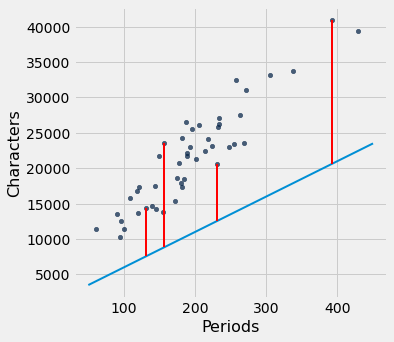

In [36]:
lw_rmse(50,1000)

Slope:       70 characters per period
Intercept:   1000 characters
Root mean squared error: 7657.15


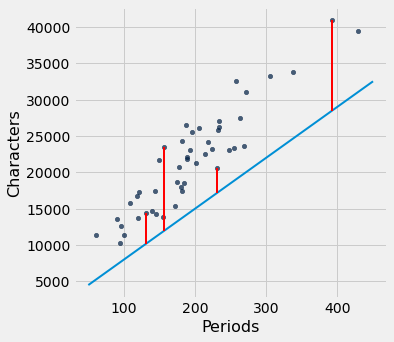

In [37]:
lw_rmse(70,1000)

Slope:       100 characters per period
Intercept:   1000 characters
Root mean squared error: 3114.33


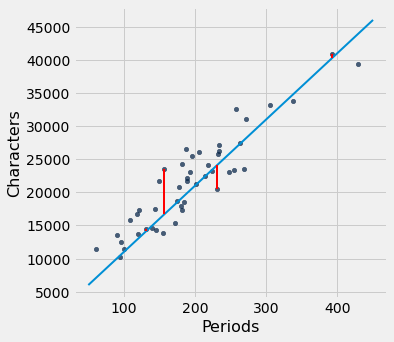

In [38]:
lw_rmse(100,1000)

Slope:       102 characters per period
Intercept:   1000 characters
Root mean squared error: 3036.57


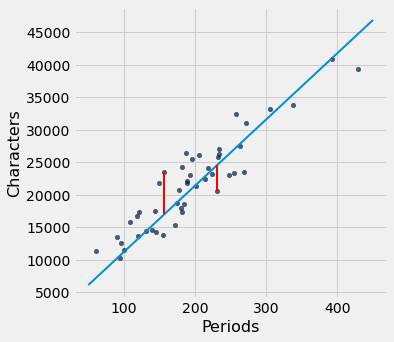

In [39]:
lw_rmse(102,1000)

Slope:       110 characters per period
Intercept:   1000 characters
Root mean squared error: 3284.41


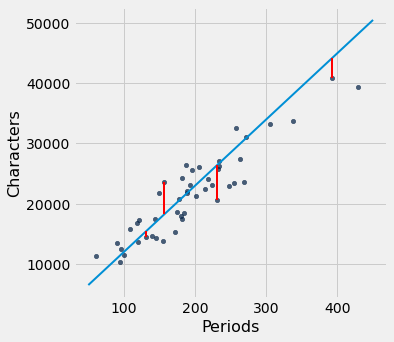

In [40]:
lw_rmse(110,1000)

Slope:       105 characters per period
Intercept:   1000 characters
Root mean squared error: 3025.85


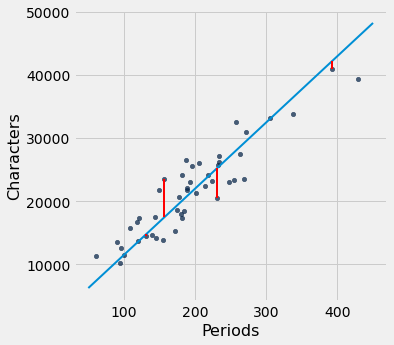

In [41]:
lw_rmse(105,1000)

Let's comput the rmse for the regression line 

<details>
<summary>Solution</summary>
  lw_rmse(slope(little_women, 1, 0), intercept(little_women, 1, 0))
</details>

Slope:       87.0 characters per period
Intercept:   4745.0 characters
Root mean squared error: 2701.69


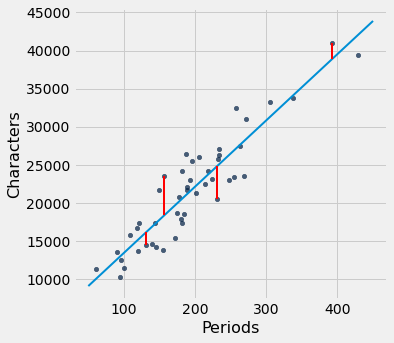

In [42]:
lw_rmse(slope(little_women, 1, 0), intercept(little_women, 1, 0))

The regression line is the line that minimzies the root mean squared error.

(back to slides)
# Least Squares

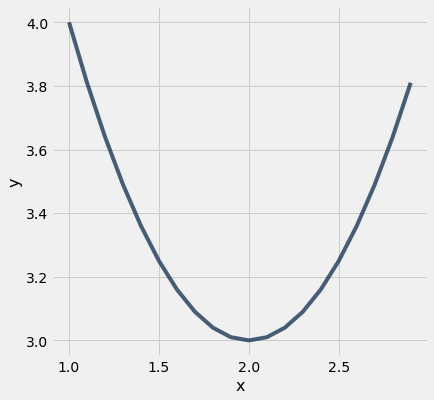

In [43]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [44]:
def f(x):
    return ((x-2)**2) + 3

What x-value gives us the smalles y-value?

In [45]:
minimize(f)

1.9999999946252267

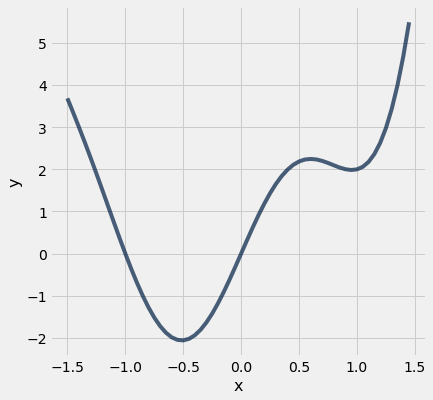

In [46]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [47]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4

What x-value gives us the smalles y-value?

In [48]:
minimize(complicated_function)

-0.5126437620940081

(back to slides)
# Minimizing MSE


In [53]:
def lw_mse(any_slope, any_intercept):
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) 

In [54]:
lw_mse(1500, 20000), lw_mse(1500, 20000)

(95488325670.93617, 95488325670.93617)

In [55]:
minimize(lw_mse)

array([  86.97784117, 4744.78484535])

In [52]:
slope(little_women, "Periods", "Characters"), intercept(little_women, "Periods", "Characters")

(86.97784125829821, 4744.784796574928)

(back to slides)
# Residuals 

Let's make a new function called residuals

<details>
<summary>Solution</summary>
  t.column(y) - predictions
</details>


In [58]:
def residuals(t, x, y):
    """ Returns residual for each prediction, 
        i.e. the difference between the true y and predicted y"""
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

In [59]:
residuals(little_women, "Periods", "Characters")

array([  575.40320561,  1051.38104687, -4278.66612724,  3820.53615806,
       -3529.13431744, -2299.68257274, -1707.88200141,  -882.04282585,
        -289.31730062, -2327.68542936,  1492.49184057, -2695.27869638,
       -1296.90701678, -2476.79622307, -3102.77406433, -4351.973493  ,
       -4347.35019161,   162.40606223,  2068.89641117, -3104.57177903,
       -4596.82409506, -1474.12574757, -3213.31158737,  3664.24809441,
         866.23164892,  3947.53901468,  1528.63050627,  2676.22022243,
        1243.37819024,   431.04580912,   496.15945945, -1069.82123843,
         853.3560315 ,  5397.91000004,  -917.33088949, -2001.5689224 ,
        5123.69412587,  3428.77990422,  -146.95704751,  1317.56688667,
        5454.35888812,  1744.82993495,  1928.97361964, -2718.67971611,
        -536.65755737,  1996.40034898,  2094.90143017])

Let's add residuals to a table and plot the table
    <details>
<summary>Solution</summary>
  little_women_fitted.with_columns('residuals', residuals(little_women, "Periods", "Characters")).scatter('Periods')
</details>

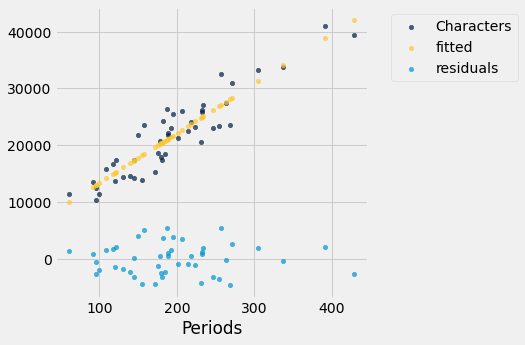

In [60]:
little_women_fitted.with_columns('residuals', residuals(little_women, "Periods", "Characters")).scatter('Periods')

**Question:** Why are the residuals on the bottom?
        <details>
<summary>Solution</summary>
  Becuase residuals show the difference between the prediction and the true value
</details>

Let's plot the residuals and the predictions seperately

In [61]:
def plot_residuals(t, x, y):
    with_residuals = t.with_columns(
        "Fitted", fitted_values(t, x, y),
        "Residual", residuals(t, x, y)/ 1000 # I did this division just for this example
    )
    with_residuals.select(x, y, 'Fitted').scatter(0)
    with_residuals.scatter(x, 'Residual')

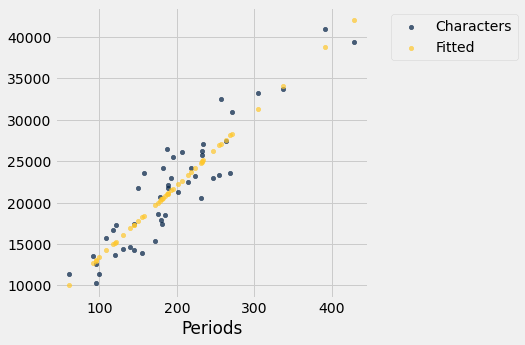

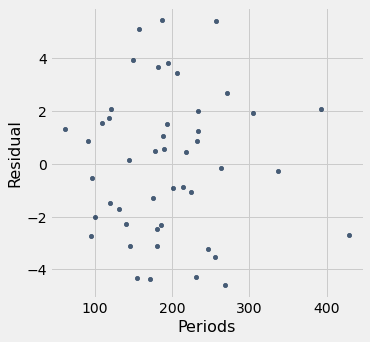

In [62]:
plot_residuals(little_women, "Periods", "Characters")

We see the residuals clustered around 0. This makes sense because the data is correlated

(back to demo)
# Nonlinear Regression

We will look at two examples


In [ ]:
shotput = Table.read_table('shotput.csv')
shotput

In [ ]:
correlation(shotput, "Weight Lifted", "Shot Put Distance")

In [ ]:
shotput.scatter('Weight Lifted')

**Question**: Is the association linear?

In [ ]:
plot_residuals(shotput, "Weight Lifted", "Shot Put Distance")

Let's look at another example

In [ ]:
height_weight = Table.read_table('us_women.csv')
height_weight

**Question**: Is the association linear?

In [ ]:
correlation(height_weight, 'height', 'ave weight')

In [ ]:
plot_residuals(height_weight, 'height', "ave weight")

(back to slides) 
# A Measure of cluster

In [ ]:
def plot_fitted(t, x, y):
    tbl = t.select(x, y)
    tbl.with_columns('Fitted Value', fitted_values(t, x, y)).scatter(0)

In [ ]:
plot_fitted(height_weight, 'height', "ave weight")

In [ ]:
weight_pred_sd = np.std(fitted_values(height_weight, 'height', 'ave weight'))
weight_observed_sd = np.std(height_weight.column('ave weight'))
print(weight_pred_sd)
print(weight_observed_sd)

In [ ]:
weight_pred_sd / weight_observed_sd

In [ ]:
correlation(height_weight, 'height', 'ave weight')